# Diabetes Classification

# Imports

In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import chi2_contingency, f_oneway

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif
from sklearn.preprocessing import PowerTransformer, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline as sklearnPipeline
from sklearn.model_selection import RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer, confusion_matrix

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE

# Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier

# Functions

In [57]:
def check_for_nulls_dupes(df):
  print(f"The amount of Null Values: {df.isna().sum()}")
  print(f"The amount of Duplicated Values {df.duplicated().sum()}")

def check_class_imbalance(target):
  unique, counts = np.unique(target, return_counts=True)
  
  plt.figure(figsize=(10, 7))
  plt.pie(counts, labels=unique, startangle=140, autopct="%1.1f%%")
  plt.title("Target Class Breakdown")
  plt.legend()
  plt.show()
  
  plt.figure(figsize=(10, 7))
  sns.countplot(x=target)
  plt.xlabel("Target Class Breakdown")
  plt.ylabel("Counts")
  plt.show()

def plot_distribution(df, kind):
  
  plt.figure(figsize=(16,16))
  columns = len(df.columns)
  rows = (columns + 3) //4
  
  for idx, col in enumerate(df.columns):
    plt.subplot(rows ,4, idx+1)
    sns.histplot(df[col], kde=True) if kind == "hist" else plt.boxplot(df[col])
    plt.title(f"Distribuition of {col}")
    plt.ylabel("Counts")

  plt.tight_layout()
  plt.show()

def aggregate_dataset(df, interested_columns, agg_col, function):
  
  plt.figure(figsize=(12,12))
  columns = len(df.columns)
  rows = (columns + 3) //4
  
  for idx, col in enumerate(interested_columns):
    plt.subplot(rows ,4, idx+1)
    grouped_df = getattr(df.groupby(agg_col)[col], function)().reset_index(name=col)
    sns.barplot(data=grouped_df, x=agg_col, y=col)
    plt.title(f"Agg of {col}")
    plt.ylabel(col)
    plt.xticks(rotation =45)
  plt.tight_layout()
  plt.show()

def scatter_plot(df, interested_columns, target):
  
  plt.figure(figsize=(12,10))
  columns = len(df.columns)
  rows = (columns + 3) //4
  
  for idx, col in enumerate(interested_columns):
    if col == target:
      continue
    plt.subplot(rows ,3, idx+1)
    sns.scatterplot(data=df, x=target, y=col, hue=col)
  plt.tight_layout()
  plt.show()

def chi_value_tests(df, interested_columns, target):
  
  for col in interested_columns:
    print(f"Column Is: {col}")
    contingency_table = pd.crosstab(df[target], df[col])
    chi2, p_val, _, _ = chi2_contingency(contingency_table)
    print(f"Chi-Square Test:\nChi2 Statistic: {chi2}, P-value: {p_val}")

# EDA Analysis

In [3]:
df = pd.read_csv("/Users/maukanmir/Downloads/data.csv", nrows=25000)
df

,year,gender,age,location,race:AfricanAmerican,race:Asian,race:Caucasian,race:Hispanic,race:Other,hypertension,heart_disease,smoking_history,bmi,hbA1c_level,blood_glucose_level,diabetes
0,2020,Female,32.0,Alabama,0,0,0,0,1,0,0,never,27.32,5.0,100,0
1,2015,Female,29.0,Alabama,0,1,0,0,0,0,0,never,19.95,5.0,90,0
2,2015,Male,18.0,Alabama,0,0,0,0,1,0,0,never,23.76,4.8,160,0
3,2015,Male,41.0,Alabama,0,0,1,0,0,0,0,never,27.32,4.0,159,0
4,2016,Female,52.0,Alabama,1,0,0,0,0,0,0,never,23.75,6.5,90,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,2019,Female,13.0,Hawaii,0,0,0,0,1,0,0,No Info,27.32,6.6,200,0
24996,2019,Male,21.0,Hawaii,0,0,1,0,0,0,0,never,20.32,4.8,155,0
24997,2019,Female,41.0,Hawaii,0,1,0,0,0,0,0,current,19.70,5.7,100,0
24998,2019,Female,80.0,Hawaii,0,0,1,0,0,0,0,No Info,27.32,6.6,100,0


In [4]:
df.dtypes

year                      int64
gender                   object
age                     float64
location                 object
race:AfricanAmerican      int64
race:Asian                int64
race:Caucasian            int64
race:Hispanic             int64
race:Other                int64
hypertension              int64
heart_disease             int64
smoking_history          object
bmi                     float64
hbA1c_level             float64
blood_glucose_level       int64
diabetes                  int64
dtype: object

# Check For Nulls And Dupes

In [6]:
check_for_nulls_dupes(df)

The amount of Null Values: year                    0
gender                  0
age                     0
location                0
race:AfricanAmerican    0
race:Asian              0
race:Caucasian          0
race:Hispanic           0
race:Other              0
hypertension            0
heart_disease           0
smoking_history         0
bmi                     0
hbA1c_level             0
blood_glucose_level     0
diabetes                0
dtype: int64
The amount of Duplicated Values 3


In [7]:
df.drop_duplicates(inplace=True)

# Check Class Imbalances

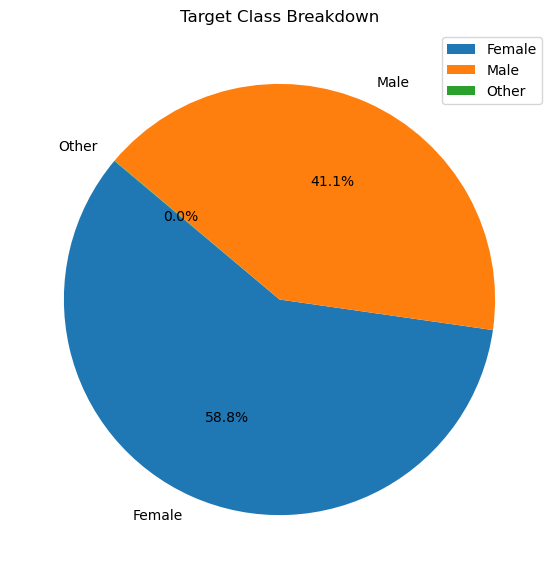

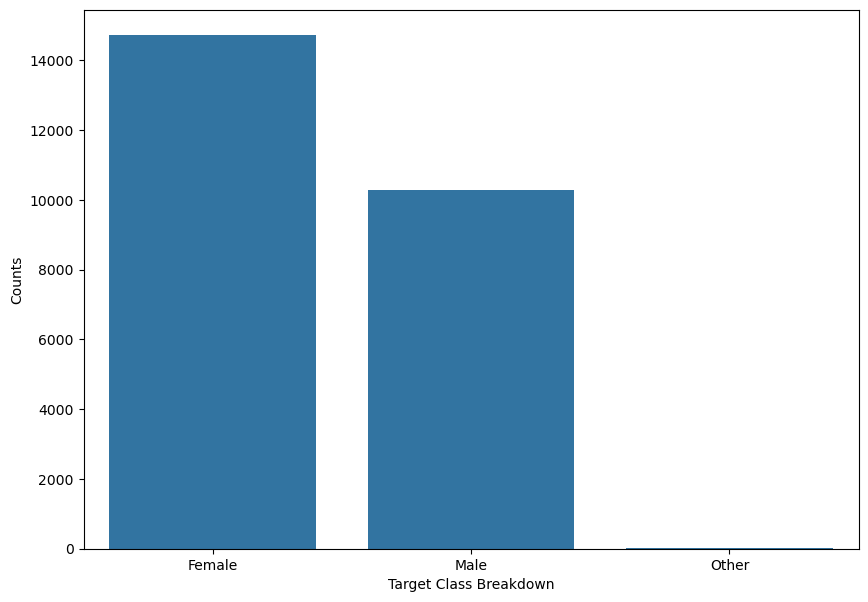

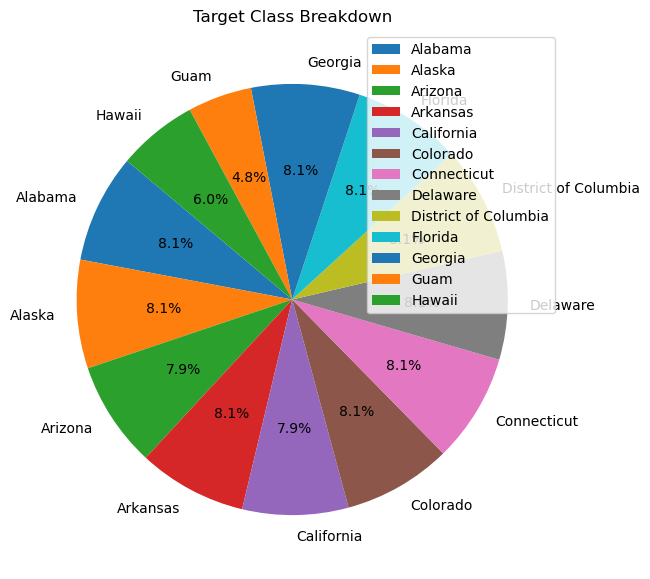

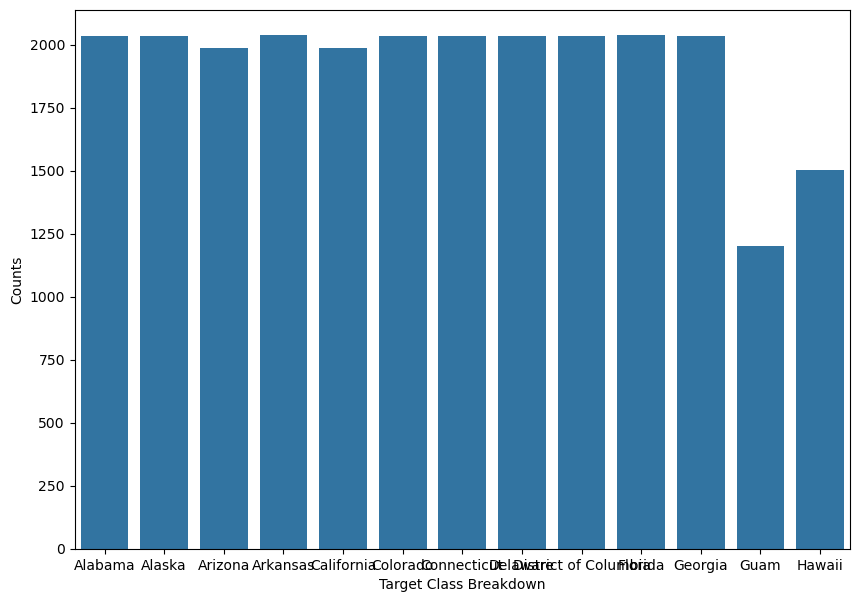

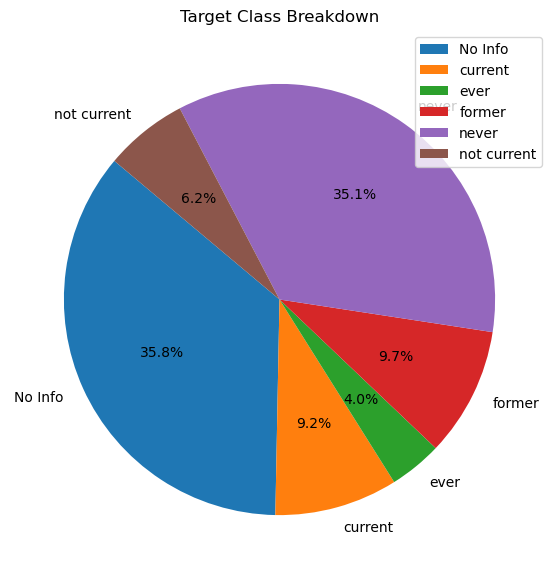

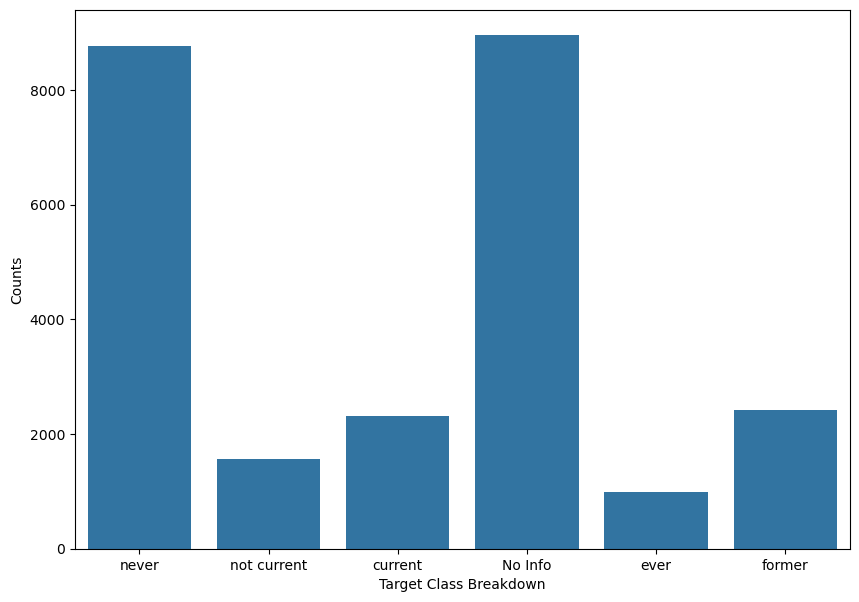

In [8]:
columns_to_check = ["gender", "location", "smoking_history"]

for col in columns_to_check:
  check_class_imbalance(df[col])

# Getting rid of ambigous columns

In [11]:
df = df[df["gender"] !="Other"]

In [12]:
df.describe()

,year,age,race:AfricanAmerican,race:Asian,race:Caucasian,race:Hispanic,race:Other,hypertension,heart_disease,bmi,hbA1c_level,blood_glucose_level,diabetes
count,24988.000000,24988.000000,24988.000000,24988.000000,24988.000000,24988.000000,24988.000000,24988.000000,24988.000000,24988.000000,24988.000000,24988.000000,24988.000000
mean,2018.411437,41.801036,0.204378,0.198255,0.201097,0.195814,0.200456,0.075436,0.038138,27.326891,5.521582,137.827717,0.085681
std,1.302629,22.423500,0.403255,0.398693,0.400828,0.396834,0.400350,0.264099,0.191534,6.632341,1.077353,41.149924,0.279898
min,2015.000000,0.080000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.190000,3.500000,80.000000,0.000000
25%,2019.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,2019.000000,43.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,2019.000000,60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,29.600000,6.200000,159.000000,0.000000
max,2022.000000,80.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,88.720000,9.000000,300.000000,1.000000


# Partition Values

In [13]:
categorical_types = df.select_dtypes(include="object")
numeric_types = df.select_dtypes(exclude="object")

# Visulizations

<AxesSubplot:>

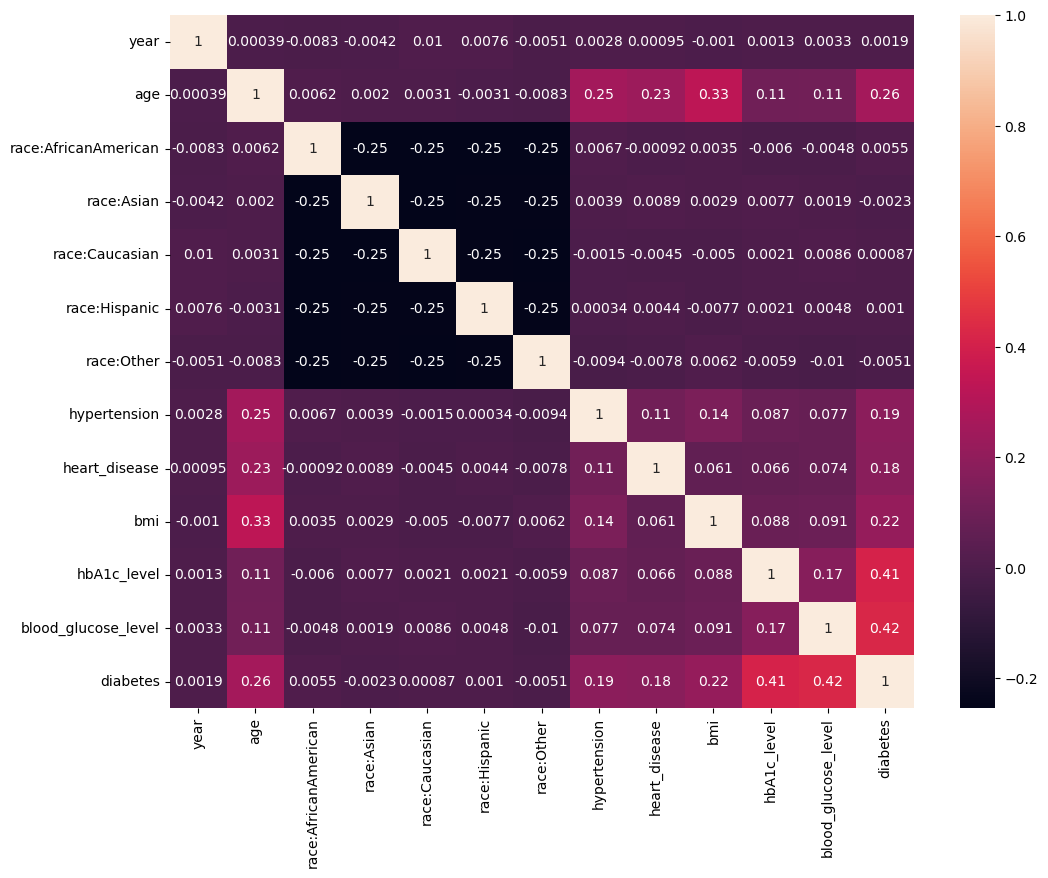

In [16]:
relations = numeric_types.corr()
plt.figure(figsize=(12, 9))
sns.heatmap(data=relations, annot=True)

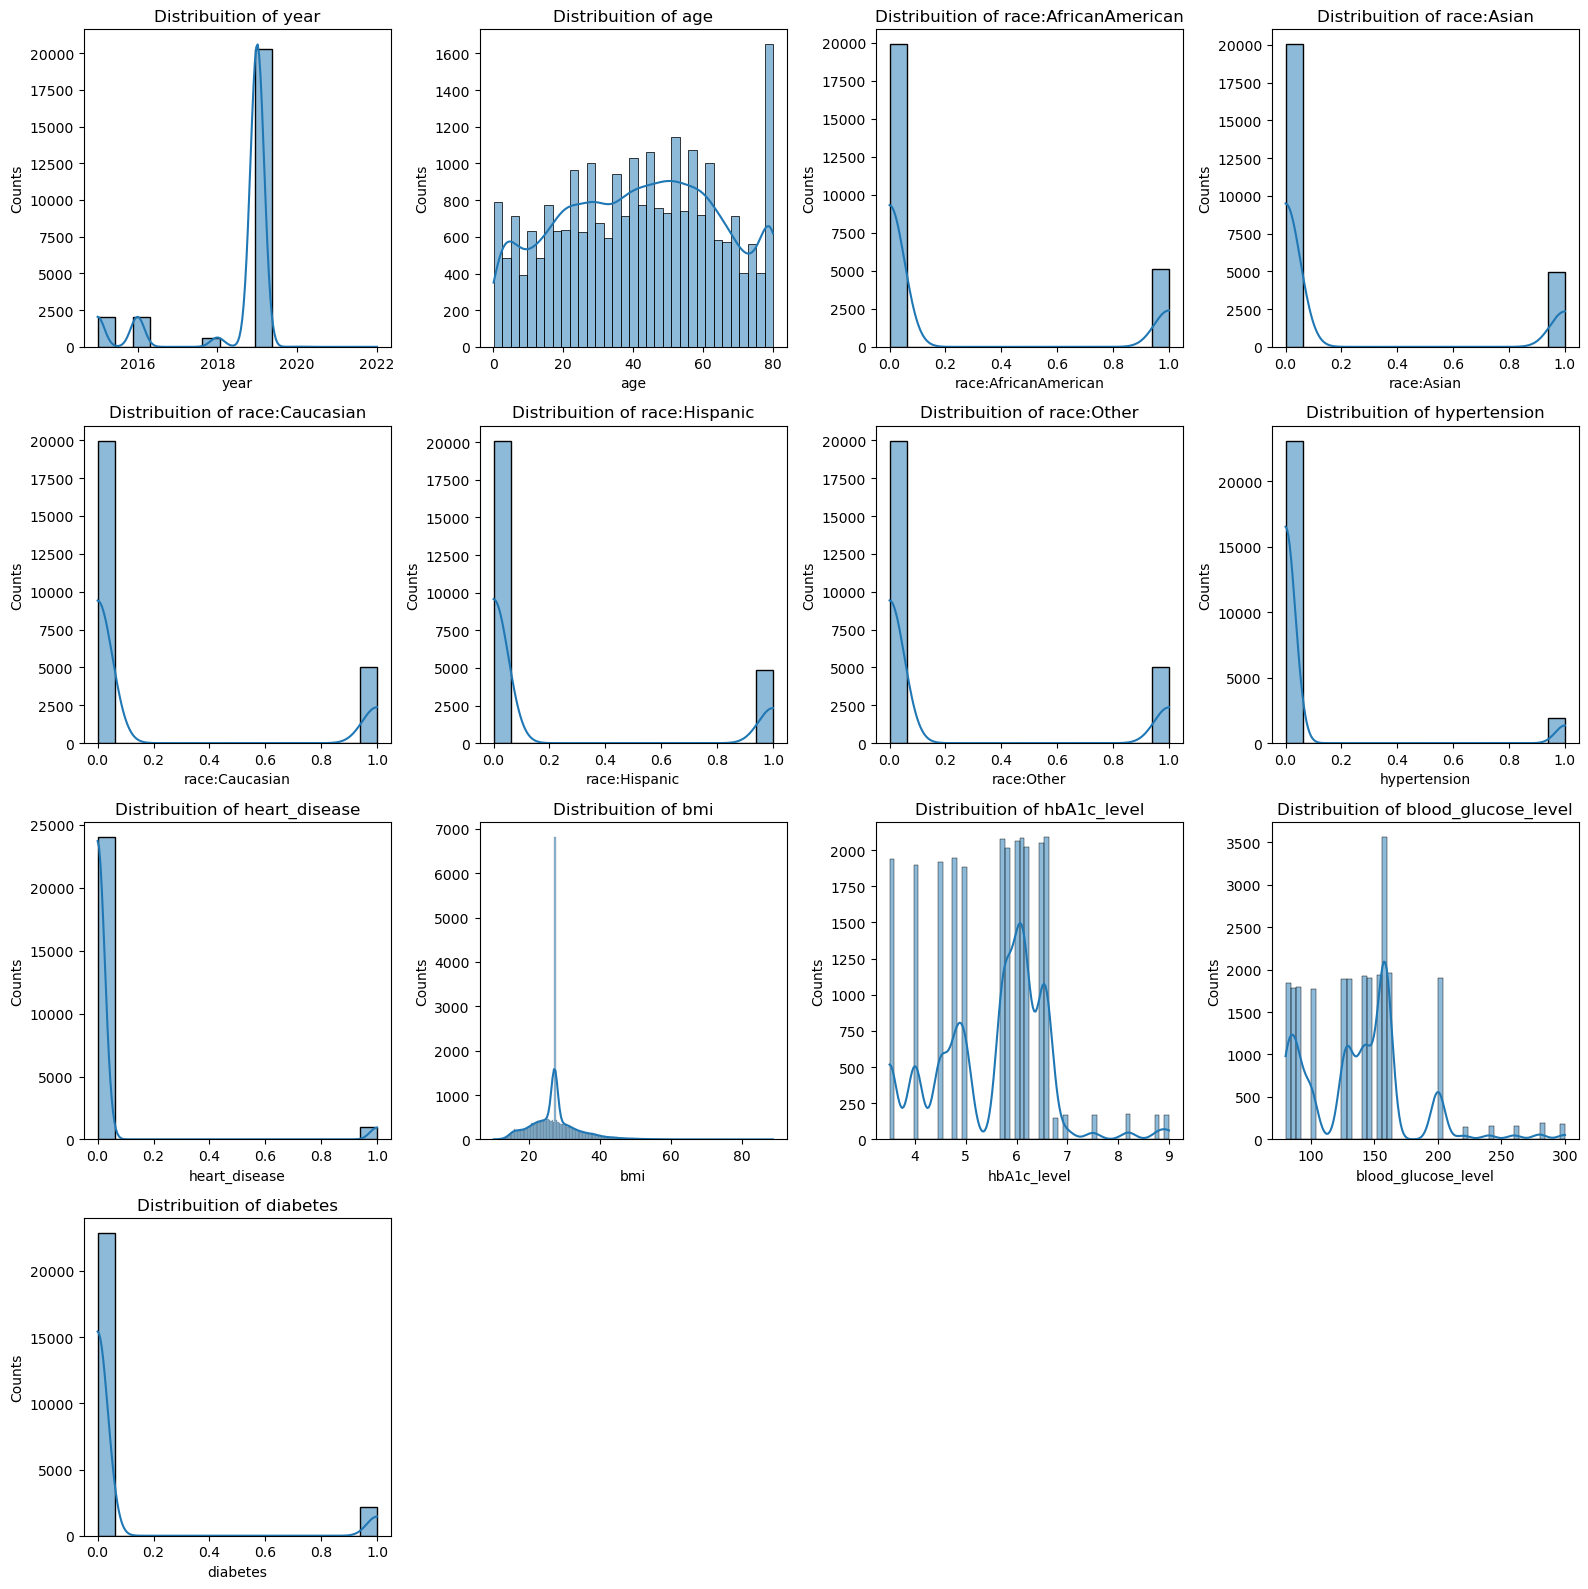

In [30]:
plot_distribution(numeric_types, "hist")

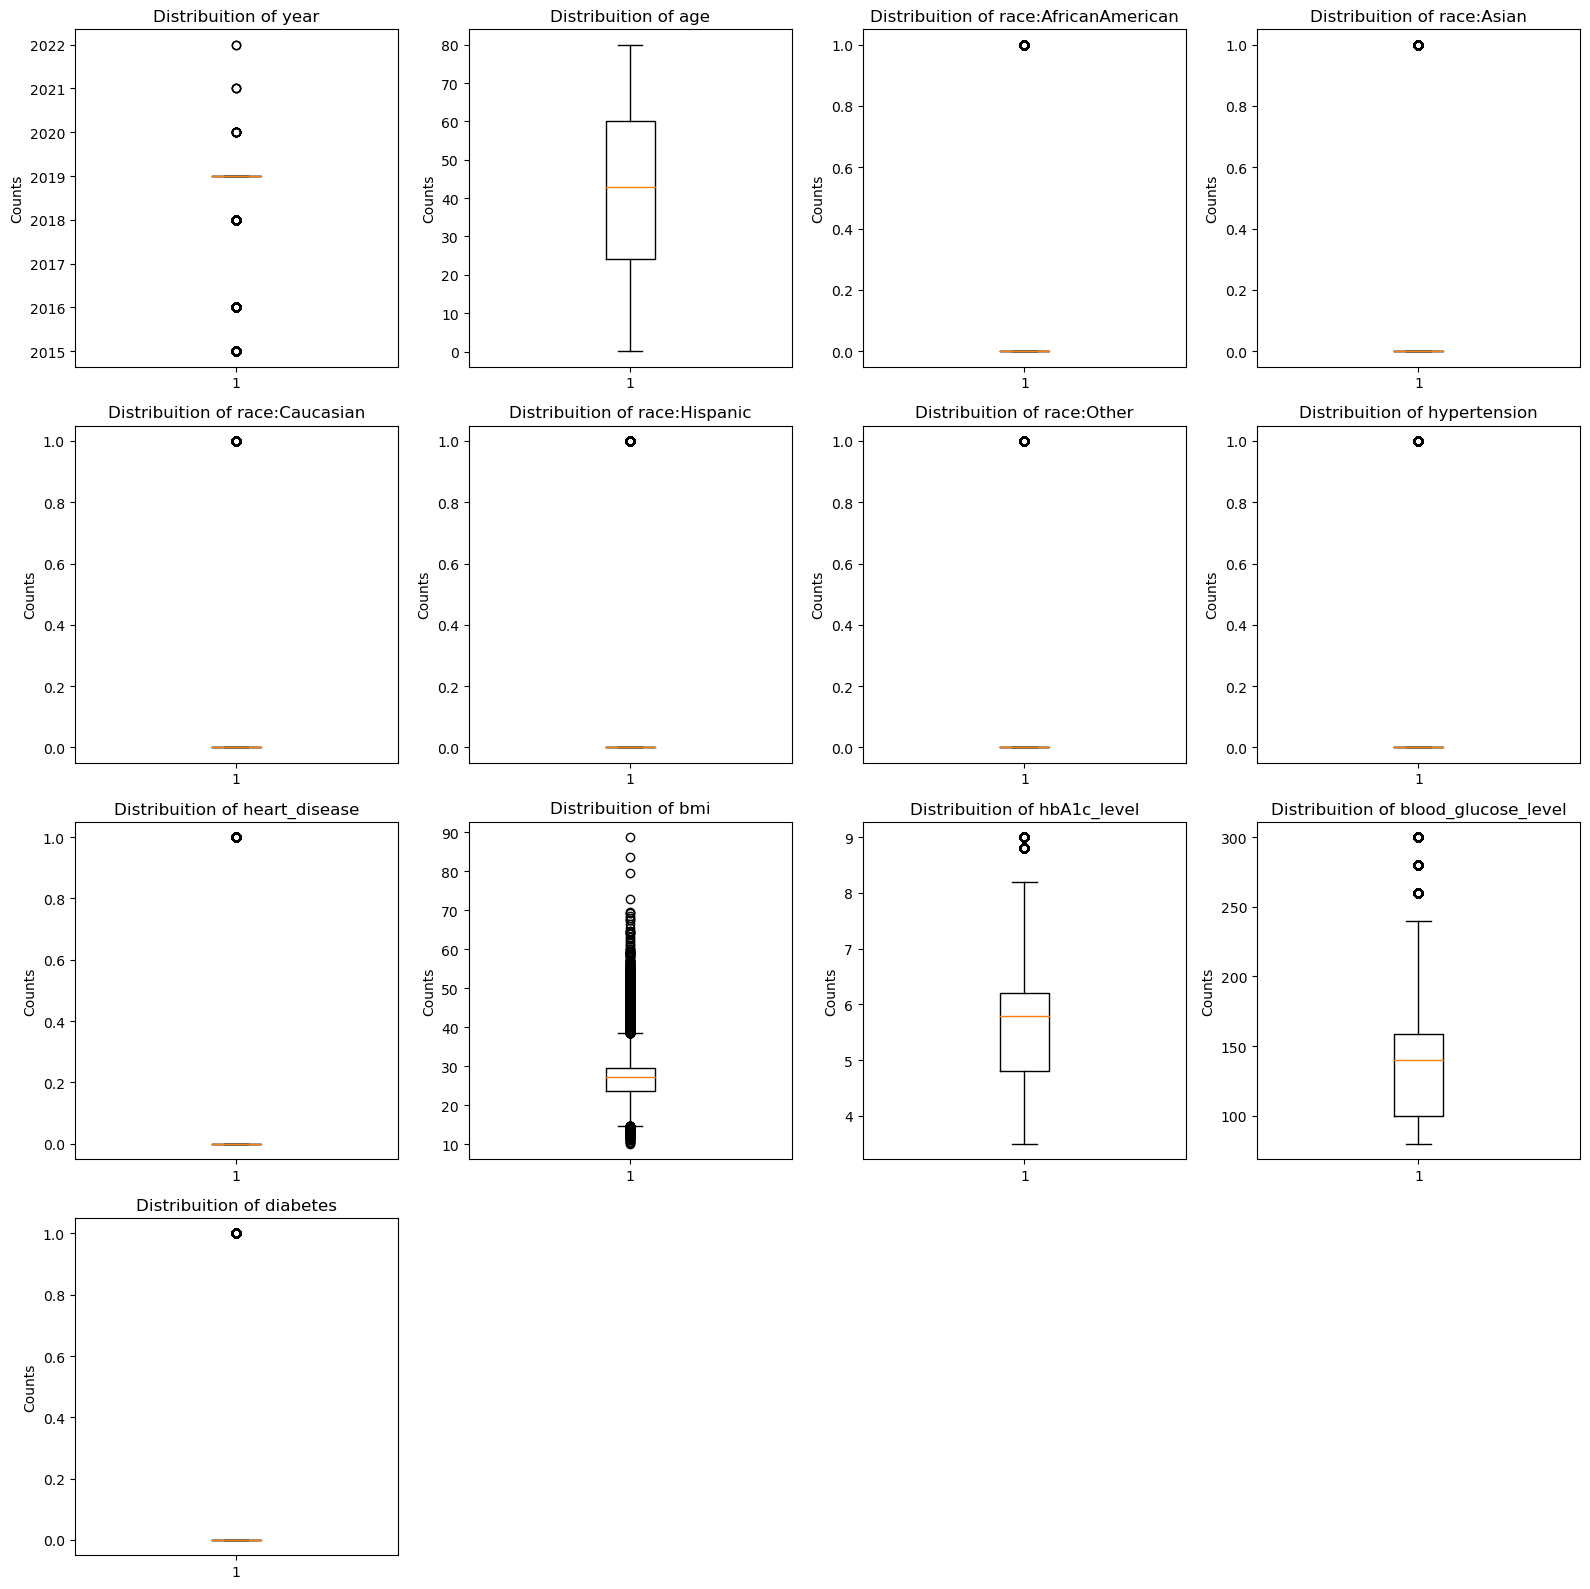

In [31]:
plot_distribution(numeric_types, "box")

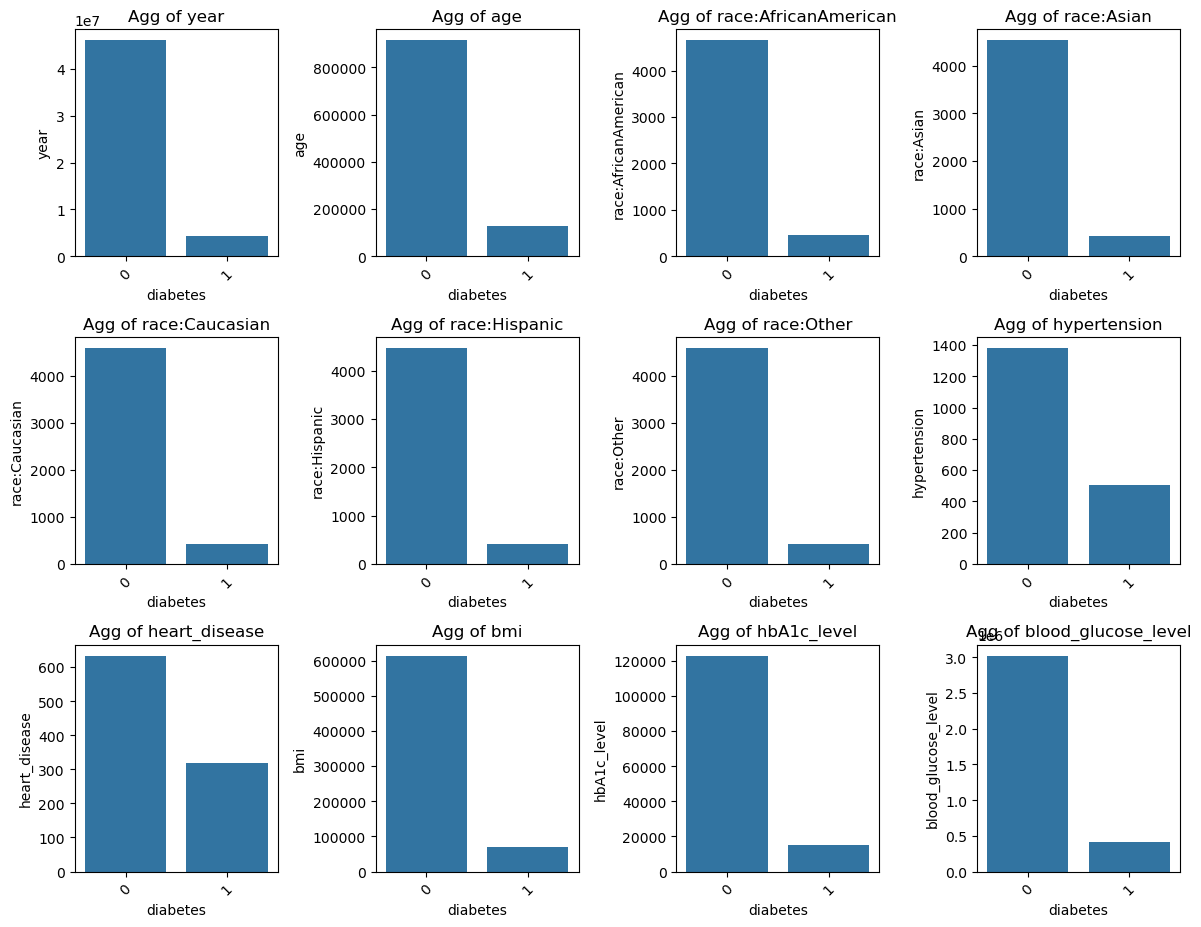

In [54]:
interested_columns = [col for col in numeric_types.columns if col != "diabetes"]
aggregate_dataset(df, interested_columns, "diabetes", "sum")

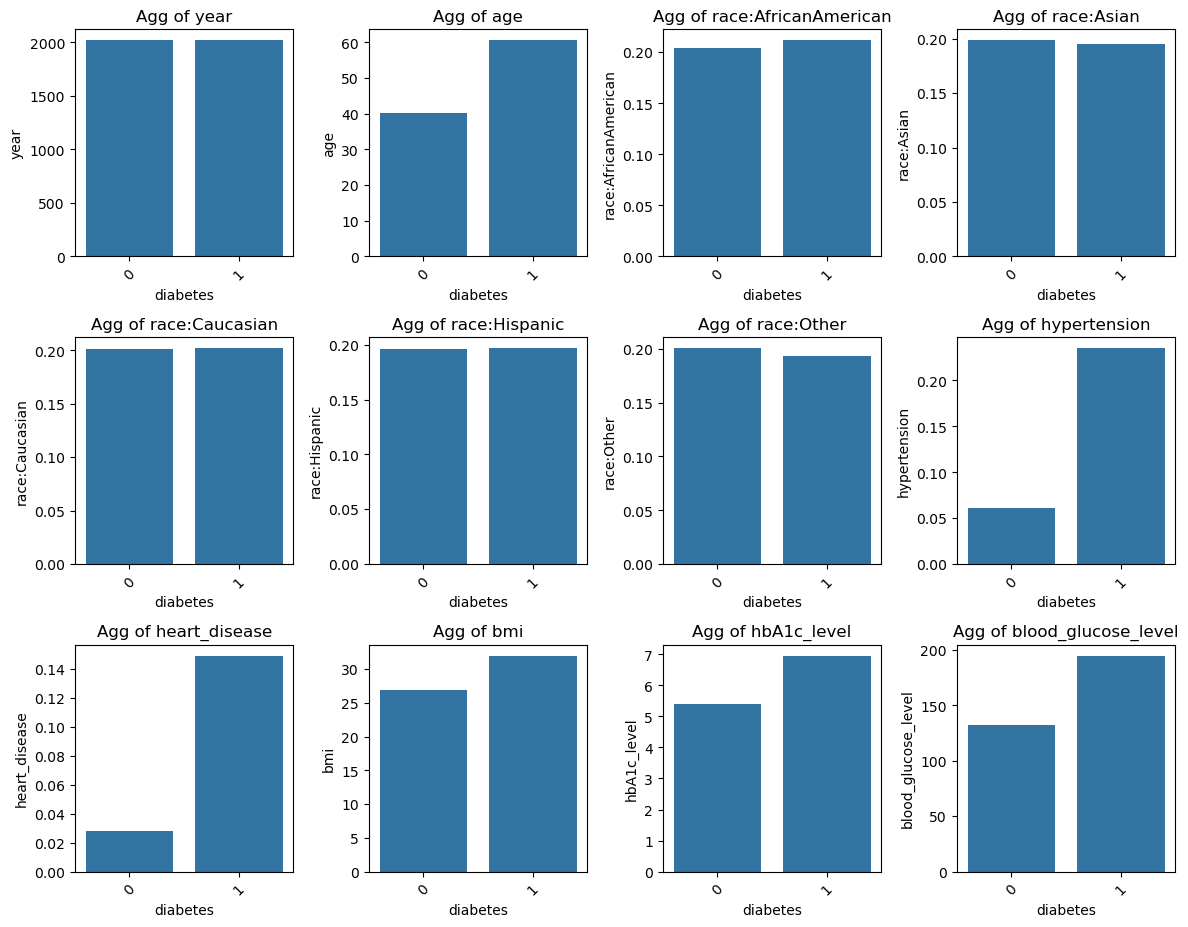

In [55]:
aggregate_dataset(df, interested_columns, "diabetes", "mean")

# Scatter Plots

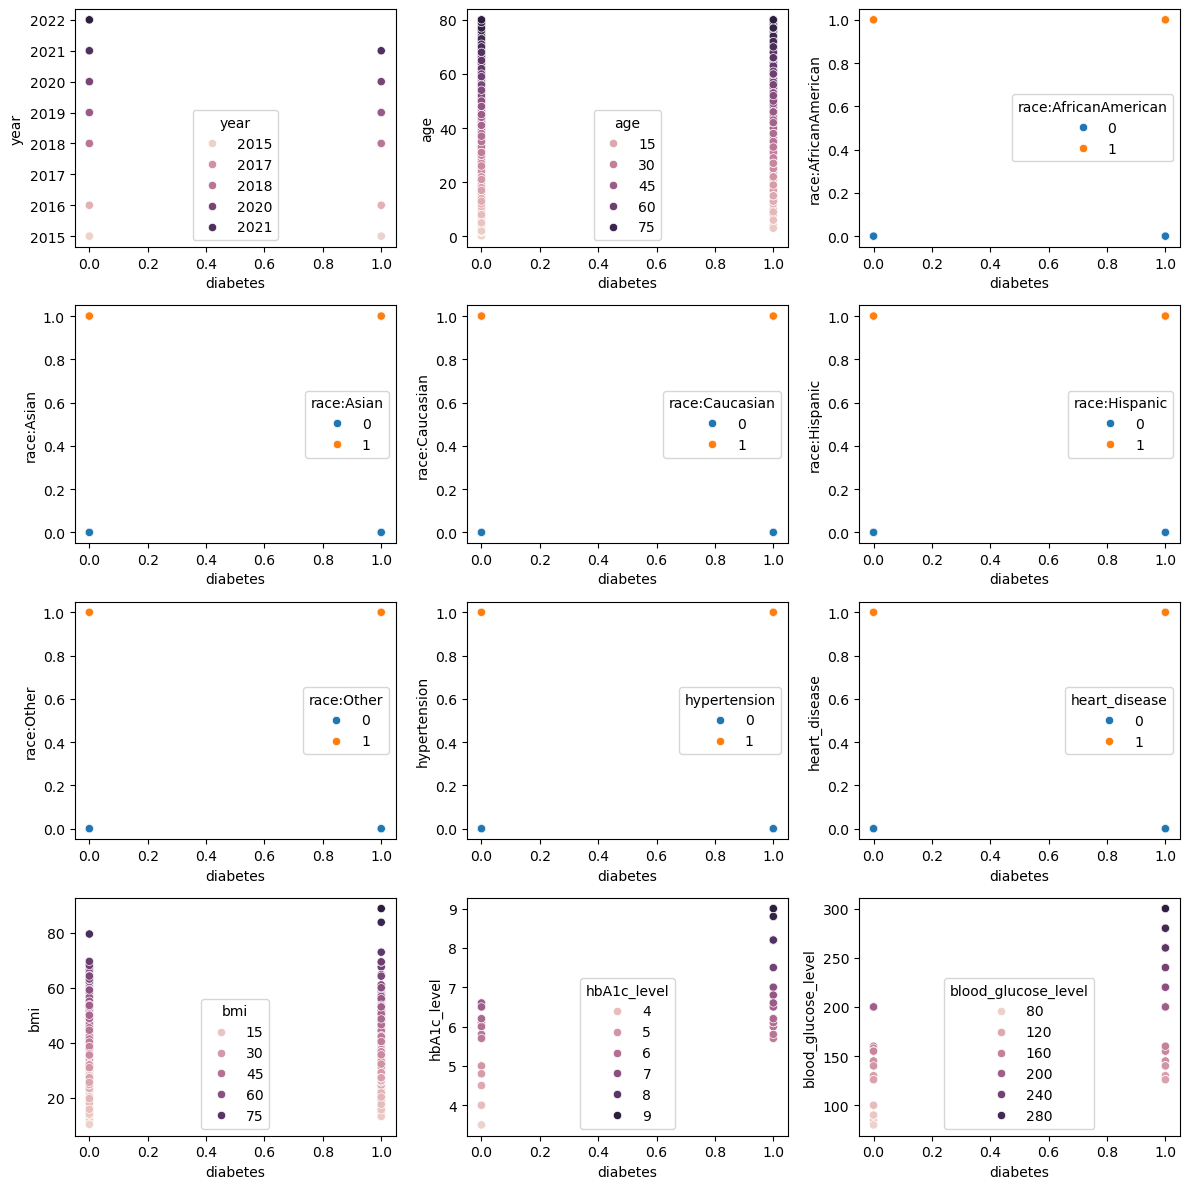

In [48]:
scatter_plot(df, interested_columns, "diabetes")

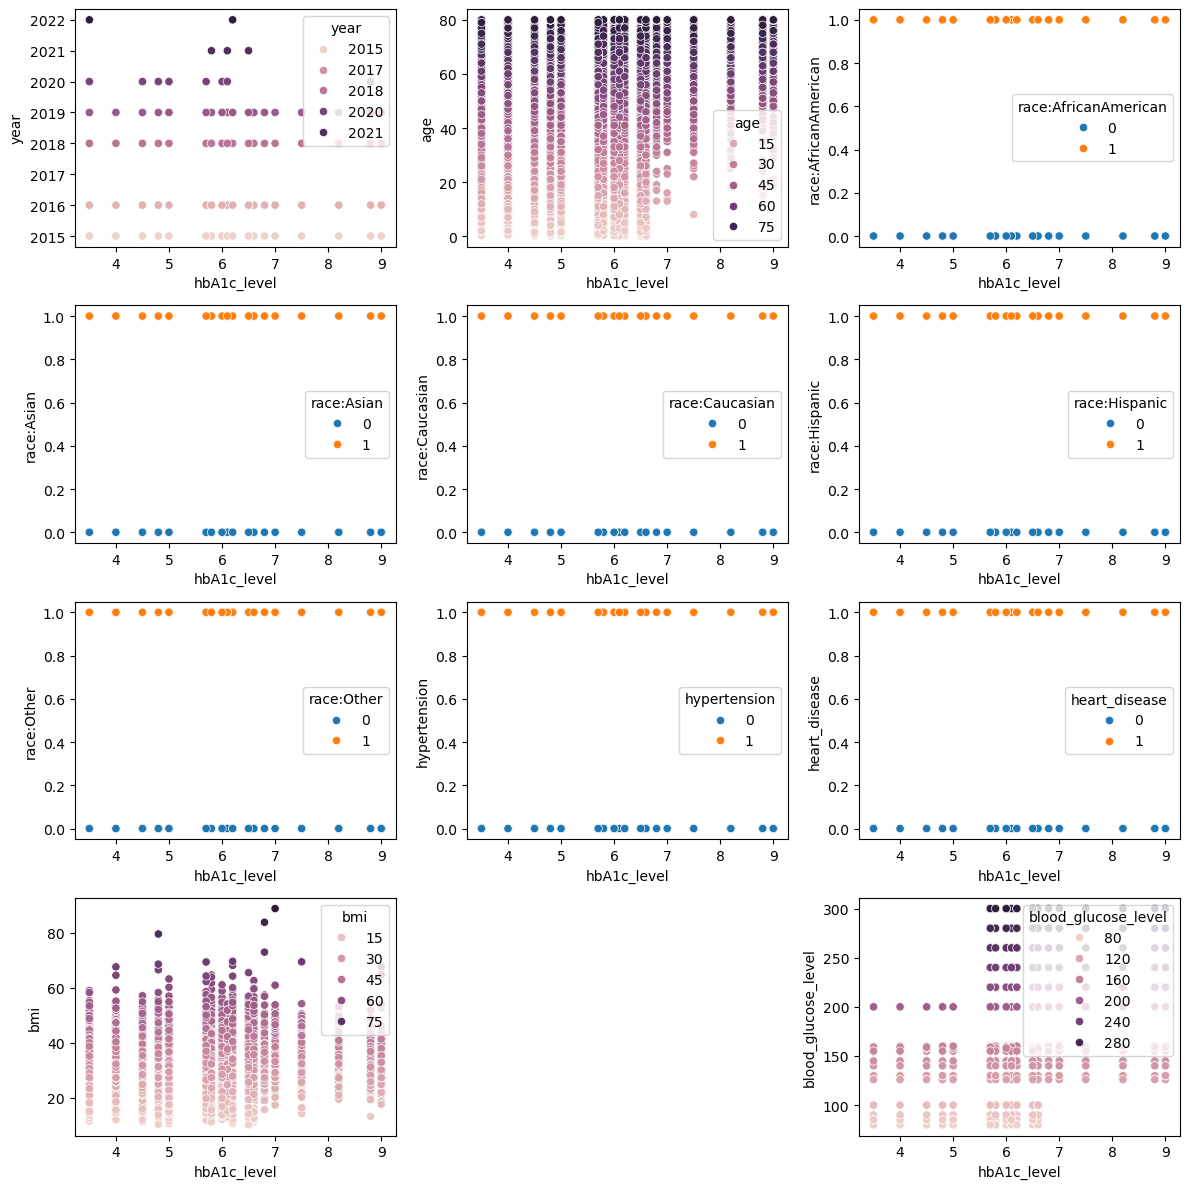

In [49]:
scatter_plot(df, interested_columns, "hbA1c_level")

# Chi Tests For Signficance

In [58]:
chi_value_tests(df, categorical_types.columns, "diabetes")

Column Is: gender
Chi-Square Test:
Chi2 Statistic: 27.837862817642367, P-value: 1.3191902459949086e-07
Column Is: location
Chi-Square Test:
Chi2 Statistic: 13.20988673546342, P-value: 0.35397165701887245
Column Is: smoking_history
Chi-Square Test:
Chi2 Statistic: 475.18169706143095, P-value: 1.8132298593380742e-100
